In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!python --version

Python 3.8.16


In [3]:
import numpy as np
import cv2
import re
from matplotlib import pyplot as plt


# ## **Use Gaussian Blurring combined with Adaptive Threshold**

def blur_and_threshold(gray):
    gray = cv2.GaussianBlur(gray, (3, 3), 2)
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    threshold = cv2.fastNlMeansDenoising(threshold, 11, 31, 9)
    return threshold


# ## **Find the Biggest Contour**

# **Note: We made sure the minimum contour is bigger than 1/10 size of the whole picture. This helps in removing very small contours (noise) from our dataset**


def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# ## Find the exact (x,y) coordinates of the biggest contour and crop it out


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


# # Transformation the image

# **1. Convert the image to grayscale**

# **2. Remove noise and smoothen out the image by applying blurring and thresholding techniques**

# **3. Use Canny Edge Detection to find the edges**

# **4. Find the biggest contour and crop it out**


def transformation(image):
    image = image.copy()

    height, width, channels = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = gray.size

    threshold = blur_and_threshold(gray)
    # We need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal
    # are sure to be edges and those below minVal are sure to be non-edges, so discarded.
    #  Those who lie between these two thresholds are classified edges or non-edges based on their connectivity.
    # If they are connected to "sure-edge" pixels, they are considered to be part of edges.
    #  Otherwise, they are also discarded
    edges = cv2.Canny(threshold, 50, 150, apertureSize=7)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_contours = []

    for cnt in contours:
        hull = cv2.convexHull(cnt)
        simplified_contours.append(cv2.approxPolyDP(hull,
                                                    0.001 * cv2.arcLength(hull, True), True))
    simplified_contours = np.array(simplified_contours)
    biggest_n, approx_contour = biggest_contour(simplified_contours, image_size)

    threshold = cv2.drawContours(image, simplified_contours, biggest_n, (0, 255, 0), 1)

    dst = 0
    if approx_contour is not None and len(approx_contour) == 4:
        approx_contour = np.float32(approx_contour)
        dst = four_point_transform(threshold, approx_contour)
    croppedImage = dst
    return croppedImage


# **Increase the brightness of the image by playing with the "V" value (from HSV)**

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


# **Sharpen the image using Kernel Sharpening Technique**


def final_image(rotated):
    # Create our shapening kernel, it must equal to one eventually
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    # applying the sharpening kernel to the input image & displaying it.
    sharpened = cv2.filter2D(rotated, -1, kernel_sharpening)
    sharpened = increase_brightness(sharpened, 30)
    return sharpened


# ## 1. Pass the image through the transformation function to crop out the biggest contour

# ## 2. Brighten & Sharpen the image to get a final cleaned image
#cv2.imwrite(path + "Final_Image2.jpg", cleaned_image)

In [4]:
def get_mask(image):
    
    image = image.copy()

    height, width, channels = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = gray.size

    threshold = blur_and_threshold(gray)
    edges = cv2.Canny(threshold, 50, 150, apertureSize=7)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_contours = []

    for cnt in contours:
        hull = cv2.convexHull(cnt)
        simplified_contours.append(cv2.approxPolyDP(hull,
                                                    0.001 * cv2.arcLength(hull, True), True))
    #simplified_contours = np.array(simplified_contours)
    biggest_n, approx_contour = biggest_contour(simplified_contours, image_size)

    #threshold = cv2.drawContours(image, simplified_contours, biggest_n, (0, 255, 0), 10)

    threshold = cv2.fillPoly(image, pts=[simplified_contours[biggest_n]], color=(0,255,0))

    #threshold

    msk = np.zeros(threshold.shape)

    msk[threshold == (0, 255, 0)] = 1

    return msk

In [5]:
from models.GeoNet.model import DocGeoNet
from models.GeoNet.unet import U2NETP
import cv2

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.io as io
import numpy as np
import cv2
import os
from PIL import Image
import argparse
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.msk = U2NETP(3, 1)
        self.DocTr = DocGeoNet()

    def forward(self, x, msk_pre, use_pre=False):
        if use_pre:
            msk = msk_pre
        else:
            msk, _1,_2,_3,_4,_5,_6 = self.msk(x)
            msk = (msk > 0.1).float()
        x = msk * x
        #print(x)

        _, _, bm = self.DocTr(x)
        bm = (2 * (bm / 255.) - 1) * 0.99
        #return bm
        return x, bm


def reload_seg_model(model, path=""):
    if not bool(path):
        return model
    else:
        model_dict = model.state_dict()
        pretrained_dict = torch.load(path, map_location='cuda:0')
        print(len(pretrained_dict.keys()))
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in model_dict}
        print(len(pretrained_dict.keys()))
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        return model


def reload_rec_model(model, path=""):
    if not bool(path):
        return model
    else:
        model_dict = model.state_dict()
        pretrained_dict = torch.load(path, map_location='cuda:0')
        print(len(pretrained_dict.keys()))
        pretrained_dict = {k[7:]: v for k, v in pretrained_dict.items() if k[7:] in model_dict}
        print(len(pretrained_dict.keys()))
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        return model




def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}




In [14]:
#img_path = "./receipt_images/003.jpg"
img_path = "/srv/data/hamin/OCR/doc_unet/original/1_1.jpg"
geonet_path = "./weights/GeoNet/DocGeoNet.pth"
unet_path = "./weights/GeoNet/preprocess.pth"


In [15]:
net = Net().to(device)

In [16]:
reload_rec_model(net.DocTr, geonet_path)
reload_seg_model(net.msk, unet_path)
net.eval()

489
489
798
798


Net(
  (msk): U2NETP(
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (rebnconv1): REBNCONV(
        (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (re

In [19]:
im = np.array(Image.open(img_path))
msk = get_mask(im)
#msk = msk[:, :, 0]
im_ori = np.array(im)[:, :, :3] / 255.  # read image 0-255 to 0-1

In [12]:
%matplotlib notebook  


<IPython.core.display.Javascript object>


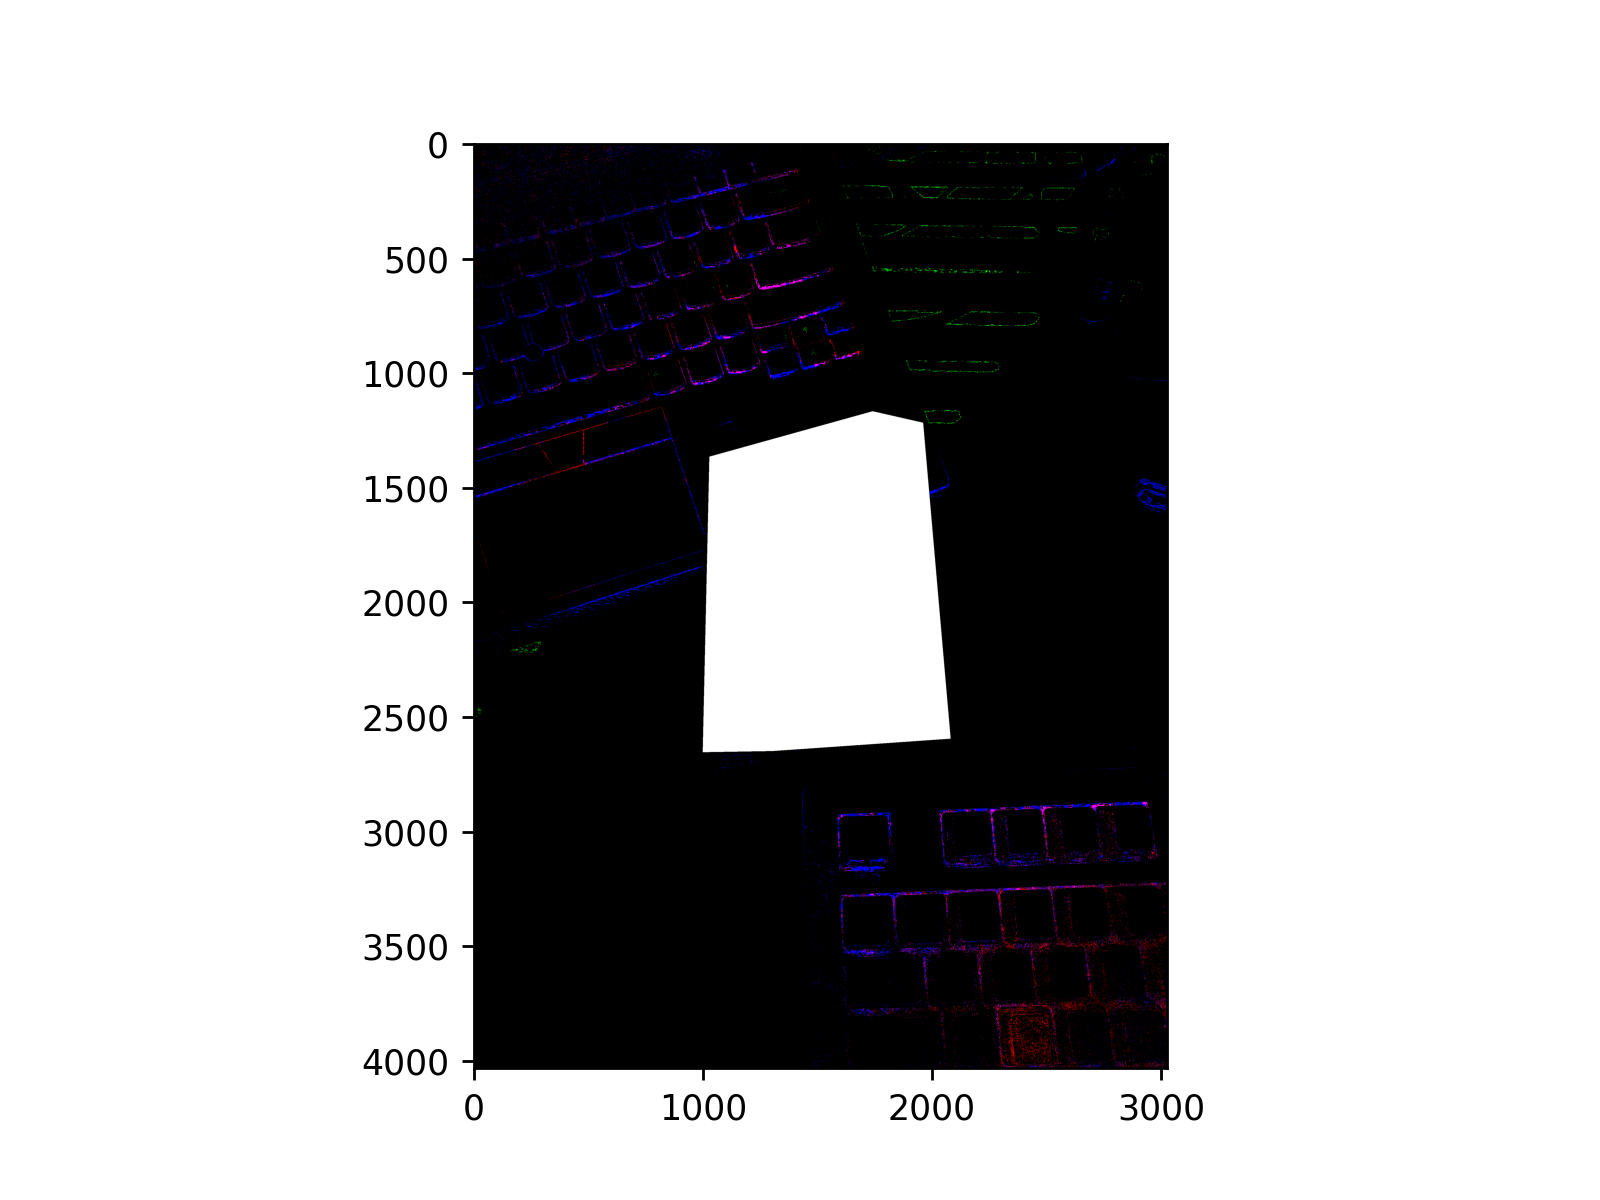

In [20]:
plt.imshow(msk)
plt.show()

In [ ]:
msk = (msk>0.9).astype(np.float32)

In [405]:
f, axarr = plt.subplots(1,2, figsize=(10,7))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# threshold = cv2.cvtColor(threshold, cv2.COLOR_BGR2RGB)
axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(msk)
axarr[1].title.set_text('Aligned')

In [351]:
h, w, _ = im_ori.shape
im = cv2.resize(im_ori, (256, 256))
im = im.transpose(2, 0, 1)
im = torch.from_numpy(im).float().unsqueeze(0)

msk = cv2.resize(msk, (256,256))
msk = torch.from_numpy(msk)

In [352]:
msk = msk.unsqueeze(0).type(torch.float32)

In [369]:
# bm = net(im.to(device))
# bm = bm.detach().cpu()

x, bm = net(im.to(device), msk.to(device), use_pre=True)
x, bm = x.detach().cpu(), bm.detach().cpu()

In [370]:
# bm0 = F.interpolate(bm[0,0].unsqueeze(0).unsqueeze(0), size=[h, w], mode='nearest')
# bm1 = F.interpolate(bm[0,1].unsqueeze(0).unsqueeze(0), size=[h, w], mode='nearest')

# bm0 = bm0[0][0].numpy()
# bm1 = bm1[0][0].numpy()

# print(bm0.shape)

In [371]:
# # save rectified image
bm0 = cv2.resize(bm[0, 0].numpy(), (w, h))  # x flow
bm1 = cv2.resize(bm[0, 1].numpy(), (w, h))  # y flow
print(bm0.shape)

(4032, 3024)


In [372]:
bm0 = cv2.blur(bm0, (3, 3))
bm1 = cv2.blur(bm1, (3, 3))
lbl = torch.from_numpy(np.stack([bm0, bm1], axis=2)).unsqueeze(0)  # h * w * 2


In [373]:
out = F.grid_sample(torch.from_numpy(im_ori).permute(2, 0, 1).unsqueeze(0).float(), lbl, align_corners=True)
print(out.shape)

torch.Size([1, 3, 4032, 3024])


In [374]:
x = (x[0] * 255).permute(1, 2, 0).numpy().astype(np.uint8)
out = (out[0] * 255).permute(1, 2, 0).numpy().astype(np.uint8)
#out = (out[0] * 255).permute(1, 2, 0).numpy()[:,:,::-1].astype(np.uint8) # changes to BRG

print(out.shape)

(4032, 3024, 3)


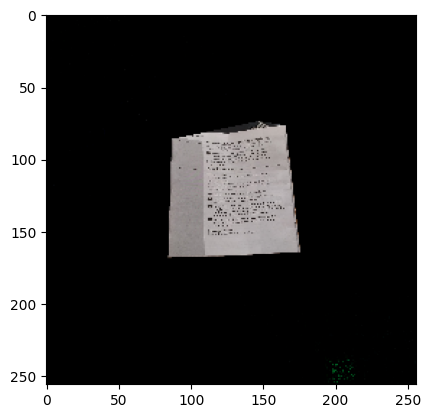

In [375]:
plt.imshow(x)

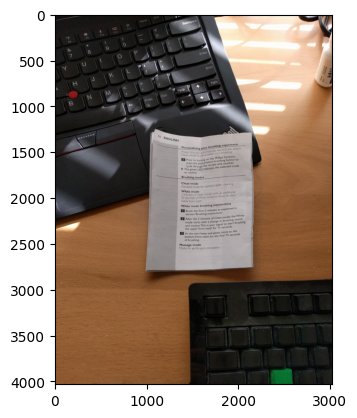

In [376]:
plt.imshow(out)

In [288]:
out_under = cv2.resize(out, (2048, 1536))  # x flow


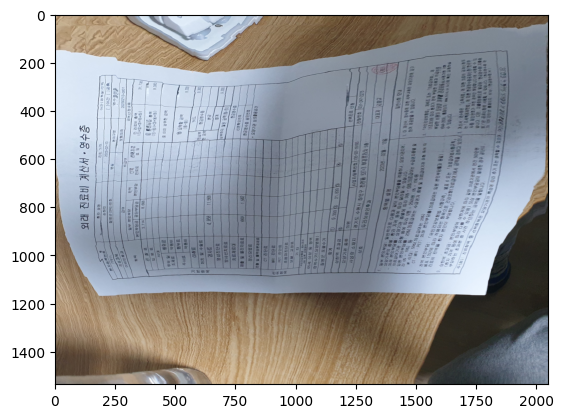

In [289]:
plt.imshow(out_under)

In [196]:
cv2.imwrite('_rec.png', out_under[:,:,::-1])


True